In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt

from model3 import *
from utils3 import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train = datasets.MNIST('../data/MNIST', train=True, download=True, transform=train_transforms())
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test = datasets.MNIST('../data/MNIST', train=False, download=True, transform=test_transforms())
# The test part of the dataset is downloaded to ../data location

100%|██████████| 9912422/9912422 [00:00<00:00, 100009889.55it/s]


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 118181164.71it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26067307.92it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7734684.84it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = torch.device("cuda" if cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model.
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
# test till help to check accuracy of our model

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
return_image_stats(train)
# Since the train data is already Normalized, we will not get the actual mean and std values

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


torch.Size([128, 1, 28, 28])
torch.Size([128])


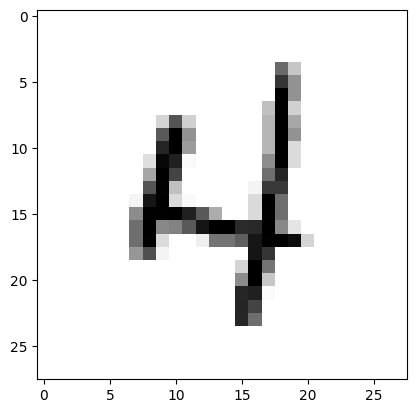

In [ ]:
return_single_image(train_loader)

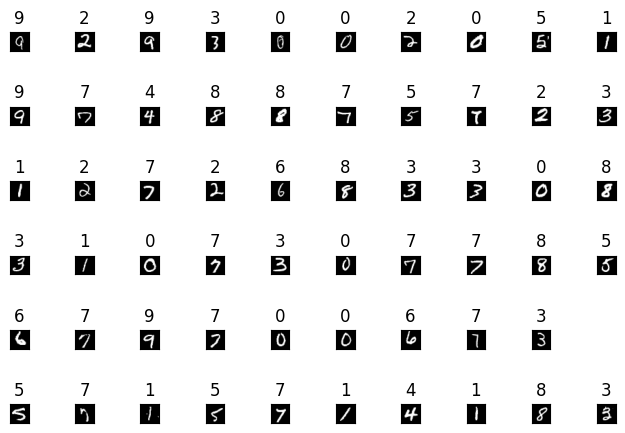

In [ ]:
return_dataset_images(train_loader,60)

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800
             ReLU-13             [-1, 20, 7, 7]               0
           Conv2d-14             [-1, 1

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.5471901297569275 Batch_id=468 Accuracy=22.63: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]



Test set: Average loss: 0.4902, Accuracy: 8493/10000 (84.93%)

EPOCH: 2


Loss=0.0796055793762207 Batch_id=468 Accuracy=92.85: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]



Test set: Average loss: 0.1313, Accuracy: 9608/10000 (96.08%)

EPOCH: 3


Loss=0.11201369762420654 Batch_id=468 Accuracy=96.12: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]



Test set: Average loss: 0.0937, Accuracy: 9699/10000 (96.99%)

EPOCH: 4


Loss=0.21638409793376923 Batch_id=468 Accuracy=96.99: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]



Test set: Average loss: 0.0693, Accuracy: 9784/10000 (97.84%)

EPOCH: 5


Loss=0.04822174087166786 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]



Test set: Average loss: 0.0720, Accuracy: 9762/10000 (97.62%)

EPOCH: 6


Loss=0.044516708701848984 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]



Test set: Average loss: 0.0572, Accuracy: 9813/10000 (98.13%)

EPOCH: 7


Loss=0.053391288965940475 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]



Test set: Average loss: 0.0567, Accuracy: 9825/10000 (98.25%)

EPOCH: 8


Loss=0.05980227515101433 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]



Test set: Average loss: 0.0527, Accuracy: 9830/10000 (98.30%)

EPOCH: 9


Loss=0.053061943501234055 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]



Test set: Average loss: 0.0464, Accuracy: 9843/10000 (98.43%)

EPOCH: 10


Loss=0.09489423781633377 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]



Test set: Average loss: 0.0595, Accuracy: 9795/10000 (97.95%)

EPOCH: 11


Loss=0.08204726874828339 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s]



Test set: Average loss: 0.0511, Accuracy: 9835/10000 (98.35%)

EPOCH: 12


Loss=0.03346031904220581 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]



Test set: Average loss: 0.0443, Accuracy: 9833/10000 (98.33%)

EPOCH: 13


Loss=0.061379168182611465 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]



Test set: Average loss: 0.0484, Accuracy: 9854/10000 (98.54%)

EPOCH: 14


Loss=0.027996957302093506 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]



Test set: Average loss: 0.0478, Accuracy: 9843/10000 (98.43%)

EPOCH: 15


Loss=0.012564421631395817 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]



Test set: Average loss: 0.0409, Accuracy: 9858/10000 (98.58%)



In [ ]:
train_losses

[tensor(2.3025, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3028, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3026, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3028, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3026, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3028, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3024, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3025, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3026, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3026, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3026, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3026, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

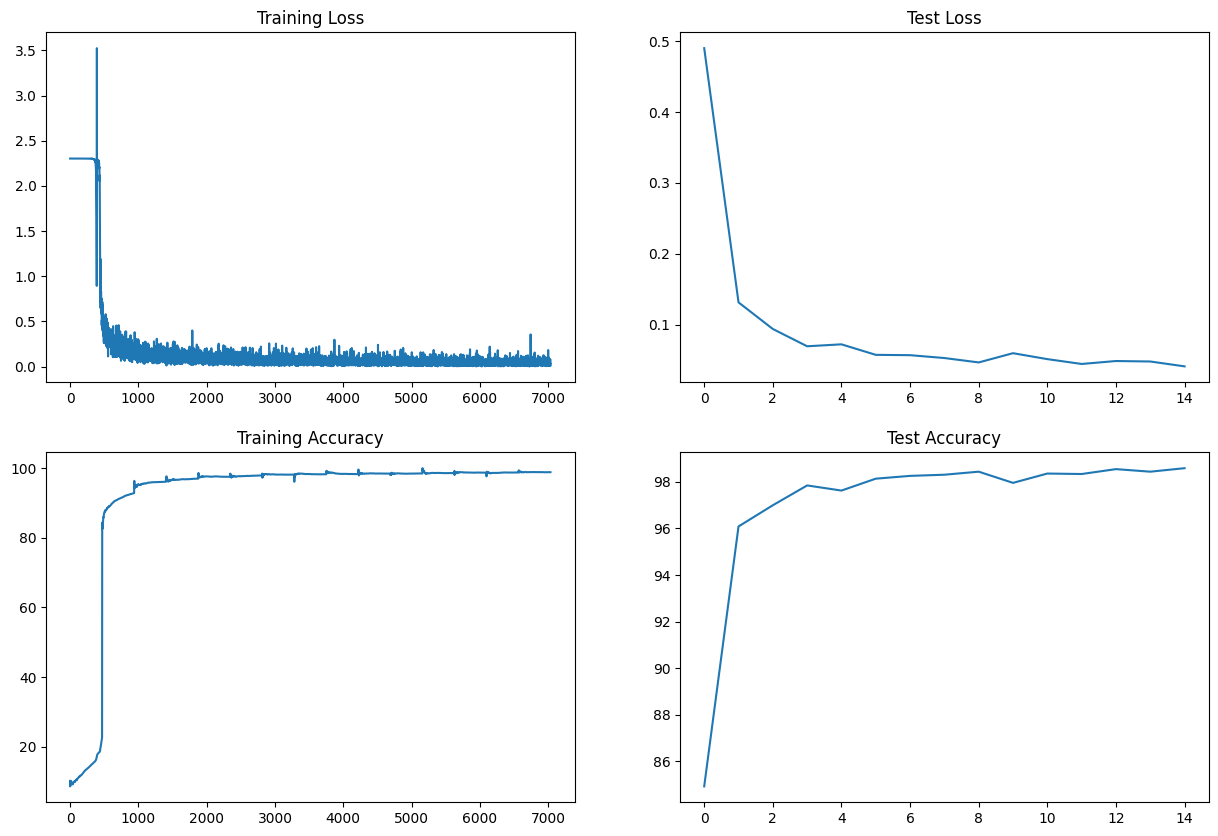

In [ ]:
draw_graphs(train_losses, train_acc, test_losses, test_acc)